In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')


In [2]:
# ============================================
# CONFIGURACIÓN
# ============================================
from pathlib import Path
# Obtiene la ruta de la carpeta donde está este script
BASE_DIR = Path.cwd()

CONFIG = {
    # Paths
    'dataset_dir': os.path.join(BASE_DIR, 'dataset'),
    # Clases
    'classes': [paper', 'rock', 'scissors'],
    
    # Hiperparámetros
    'batch_size': 8,  # Más pequeño por memoria (secuencias temporales)
    'epochs': 30,
    'learning_rate': 5e-5,  # Más bajo por LSTM
    'weight_decay': 1e-4,
    
    # Secuencias temporales
    'emg_seq_len': 400,   # Frames de EMG a usar
    'imu_seq_len': 100,   # Frames de IMU a usar
    
    # Training
    'num_workers': 0,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    
    # Modo de entrenamiento
    'use_myo': True,  # False = solo RGB+Landmarks
}


In [3]:
# ============================================
# FUNCIONES DE PREPROCESAMIENTO
# ============================================
def normalize_emg(emg_data):
    """
    Normaliza señales EMG a rango [-1, 1]
    EMG range típico: [-128, 127]
    """
    return emg_data / 128.0

def normalize_imu(orientation, acceleration, gyroscope):
    """
    Normaliza datos IMU
    - Orientation (quaternions): ya normalizado [-1, 1]
    - Acceleration: normalizar por gravedad (~9.8)
    - Gyroscope: normalizar por rango típico
    """
    acc_norm = acceleration / 10.0  # Aproximado
    gyro_norm = gyroscope / 100.0   # Aproximado
    
    return np.concatenate([orientation, acc_norm, gyro_norm], axis=1)

def pad_or_truncate_sequence(sequence, target_length):
    """
    Ajusta longitud de secuencia temporal
    - Si es más corta: pad con zeros
    - Si es más larga: truncate
    """
    current_length = len(sequence)

    if current_length == 0:
        # Si no hay datos, retornar zeros
        return np.zeros((target_length, sequence.shape[1] if len(sequence.shape) > 1 else 1), dtype=np.float32)
    
    if current_length < target_length:
        # Pad con últimos valores
        padding = np.repeat(sequence[-1:], target_length - current_length, axis=0)
        return np.vstack([sequence, padding])
    else:
        # Truncate
        return sequence[:target_length]

def load_landmarks(landmarks_path):
    """
    Carga landmarks desde CSV
    Formato: landmark_id, x, y, z
    Retorna: (21, 3) array con [x, y, z]
    """
    df = pd.read_csv(landmarks_path)
    # Extraer solo x, y, z (ignorar landmark_id)
    landmarks = df[['x', 'y', 'z']].values.astype(np.float32)
    return landmarks  # (21, 3)

def load_emg(emg_path):
    """
    Carga EMG desde CSV
    Formato: index, timestamp, ch0, ch1, ..., ch7
    Retorna: (seq_len, 8) array normalizado
    """
    df = pd.read_csv(emg_path)
    # Extraer canales (columnas ch0-ch7)
    emg_cols = [f'ch{i}' for i in range(8)]
    emg_data = df[emg_cols].values.astype(np.float32)
    return normalize_emg(emg_data)  # (seq_len, 8)

def load_imu(imu_path):
    """
    Carga IMU desde CSV
    Formato: index, timestamp, ori_x, ori_y, ori_z, ori_w, acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z
    Retorna: (seq_len, 10) array normalizado
    """
    df = pd.read_csv(imu_path)
    
    # Extraer columnas
    orientation = df[['ori_x', 'ori_y', 'ori_z', 'ori_w']].values
    acceleration = df[['acc_x', 'acc_y', 'acc_z']].values
    gyroscope = df[['gyr_x', 'gyr_y', 'gyr_z']].values
    
    return normalize_imu(orientation, acceleration, gyroscope)  # (seq_len, 10)



In [ ]:
# ============================================
# INDEXAR DATASET
# ============================================
def index_synchronized_dataset(base_dir):
    """
    Indexa el dataset sincronizado creado por dataset_creator_myo.py
    
    Returns:
        List of dicts con rutas a todos los archivos de cada sample
    """
    samples = []
    
    images_dir = os.path.join(base_dir, 'images')
    landmarks_dir = os.path.join(base_dir, 'landmarks')
    emg_dir = os.path.join(base_dir, 'emg')
    imu_dir = os.path.join(base_dir, 'imu')
    
    # Iterar por cada clase
    for gesture in CONFIG['classes']:
        gesture_img_dir = os.path.join(images_dir, gesture)
        
        if not os.path.exists(gesture_img_dir):
            print(f"[WARNING] No existe carpeta: {gesture_img_dir}")
            continue
        
        # Listar todas las imágenes
        image_files = sorted([f for f in os.listdir(gesture_img_dir) if f.endswith('.jpg')])
        
        for img_file in image_files:
            # Extraer base name: rock_0001.jpg -> rock_0001
            base_name = img_file.replace('.jpg', '')
            
            # Construir rutas
            img_path = os.path.join(gesture_img_dir, img_file)
            landmarks_path = os.path.join(landmarks_dir, f"{base_name}_landmarks.csv")
            emg_path = os.path.join(emg_dir, f"{base_name}_emg.csv")
            imu_path = os.path.join(imu_dir, f"{base_name}_imu.csv")
            meta_path = os.path.join(landmarks_dir, f"{base_name}_meta.json")
            
            # Verificar que todos los archivos existan
            if all(os.path.exists(p) for p in [img_path, landmarks_path, emg_path, imu_path]):
                samples.append({
                    'image_path': img_path,
                    'landmarks_path': landmarks_path,
                    'emg_path': emg_path,
                    'imu_path': imu_path,
                    'meta_path': meta_path if os.path.exists(meta_path) else None,
                    'label': gesture
                })
            else:
                print(f"[WARNING] Archivos incompletos para: {base_name}")
    
    return samples

In [ ]:
# ============================================
# DATASET CLASS
# ============================================
class SynchronizedMultimodalDataset(Dataset):
    """
    Dataset para datos sincronizados: RGB + Landmarks + EMG + IMU
    """
    def __init__(self,
                 samples,
                 img_size=(224, 224),
                 transform=None,
                 landmark_stats=None,
                 emg_seq_len=400,
                 imu_seq_len=100,
                 use_myo=True):
        
        self.samples = samples
        self.transform = transform
        self.use_myo = use_myo
        self.emg_seq_len = emg_seq_len
        self.imu_seq_len = imu_seq_len
        
        self.class_to_idx = {cls: idx for idx, cls in enumerate(CONFIG['classes'])}
        
        # Normalización de landmarks
        if landmark_stats:
            self.lm_mean, self.lm_std = landmark_stats['mean'], landmark_stats['std']
        else:
            self.lm_mean, self.lm_std = self._compute_landmark_stats()
        
        # Transform por defecto
        self.default_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def _compute_landmark_stats(self):
        """Calcula media y std de landmarks"""
        all_landmarks = []
        sample_size = min(100, len(self.samples))
        
        for i in range(sample_size):
            lm = load_landmarks(self.samples[i]['landmarks_path'])
            all_landmarks.append(lm.flatten())
        
        all_landmarks = np.array(all_landmarks)
        mean = all_landmarks.mean(axis=0)
        std = all_landmarks.std(axis=0) + 1e-8
        
        return mean.astype(np.float32), std.astype(np.float32)
    
    def get_stats(self):
        return {'mean': self.lm_mean, 'std': self.lm_std}
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # 1. CARGAR IMAGEN
        image = Image.open(sample['image_path']).convert('RGB')
        image = self.transform(image) if self.transform else self.default_transform(image)
        
        # 2. CARGAR LANDMARKS
        landmarks = load_landmarks(sample['landmarks_path'])  # (21, 3)
        landmarks_flat = landmarks.flatten()  # (63,)
        landmarks_flat = (landmarks_flat - self.lm_mean) / self.lm_std
        
        # 3. CARGAR MYO (EMG + IMU) si está habilitado
        if self.use_myo:
            try:
                emg_raw = load_emg(sample['emg_path'])  # (seq_len, 8)
                imu_raw = load_imu(sample['imu_path'])  # (seq_len, 10)
                
                # Ajustar longitud
                emg_seq = pad_or_truncate_sequence(emg_raw, self.emg_seq_len)
                imu_seq = pad_or_truncate_sequence(imu_raw, self.imu_seq_len)
                
                emg_seq = torch.from_numpy(emg_seq).float()
                imu_seq = torch.from_numpy(imu_seq).float()
                
            except Exception as e:
                print(f"[ERROR] Cargando Myo para {sample['image_path']}: {e}")
                # Fallback: zeros
                emg_seq = torch.zeros((self.emg_seq_len, 8), dtype=torch.float32)
                imu_seq = torch.zeros((self.imu_seq_len, 10), dtype=torch.float32)
        else:
            emg_seq = torch.zeros((self.emg_seq_len, 8), dtype=torch.float32)
            imu_seq = torch.zeros((self.imu_seq_len, 10), dtype=torch.float32)
        
        # Label
        label = self.class_to_idx[sample['label']]
        
        return {
            'image': image,
            'landmarks': torch.from_numpy(landmarks_flat).float(),
            'emg': emg_seq,
            'imu': imu_seq,
            'label': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# ============================================
# CREAR DATALOADERS
# ============================================
def create_dataloaders():
    """Crea dataloaders con datos sincronizados"""
    
    print("\n" + "="*60)
    print("CREANDO DATALOADERS - DATASET SINCRONIZADO")
    print("="*60)
    
    # Indexar dataset
    print("\n1. Indexando dataset...")
    samples = index_synchronized_dataset(CONFIG['dataset_dir'])
    
    if len(samples) == 0:
        raise ValueError("No se encontraron samples. Verifica la estructura del dataset.")
    
    print(f"   Total samples: {len(samples)}")
    
    # Distribución
    labels = [s['label'] for s in samples]
    from collections import Counter
    dist = Counter(labels)
    print(f"\n2. Distribución de clases:")
    for cls, count in dist.items():
        print(f"   {cls}: {count} ({count/len(samples)*100:.1f}%)")
    
    # Split estratificado
    train_val, test_samples = train_test_split(samples, test_size=0.15, 
                                               stratify=labels, random_state=42)
    train_labels = [s['label'] for s in train_val]
    train_samples, val_samples = train_test_split(train_val, test_size=0.176,
                                                  stratify=train_labels, random_state=42)
    
    print(f"\n3. Split: Train={len(train_samples)} | Val={len(val_samples)} | Test={len(test_samples)}")
    
    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(0.3),
        transforms.ColorJitter(0.2, 0.2, 0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Crear datasets
    train_ds = SynchronizedMultimodalDataset(
        train_samples,
        transform=train_transform,
        emg_seq_len=CONFIG['emg_seq_len'],
        imu_seq_len=CONFIG['imu_seq_len'],
        use_myo=CONFIG['use_myo']
    )
    
    stats = train_ds.get_stats()
    
    val_ds = SynchronizedMultimodalDataset(
        val_samples,
        transform=val_transform,
        landmark_stats=stats,
        emg_seq_len=CONFIG['emg_seq_len'],
        imu_seq_len=CONFIG['imu_seq_len'],
        use_myo=CONFIG['use_myo']
    )
    
    test_ds = SynchronizedMultimodalDataset(
        test_samples,
        transform=val_transform,
        landmark_stats=stats,
        emg_seq_len=CONFIG['emg_seq_len'],
        imu_seq_len=CONFIG['imu_seq_len'],
        use_myo=CONFIG['use_myo']
    )
    
    # DataLoaders
    train_loader = DataLoader(train_ds, CONFIG['batch_size'], shuffle=True, 
                             num_workers=CONFIG['num_workers'], drop_last=True)
    val_loader = DataLoader(val_ds, CONFIG['batch_size'], shuffle=False,
                           num_workers=CONFIG['num_workers'], drop_last=True)
    test_loader = DataLoader(test_ds, CONFIG['batch_size'], shuffle=False,
                            num_workers=CONFIG['num_workers'], drop_last=False)
    
    print(f"\n✓ DataLoaders creados")
    return train_loader, val_loader, test_loader


In [ ]:
# ============================================
# TRAINING LOOP
# ============================================
def train():
    """Función principal de entrenamiento"""
    
    print("="*60)
    print("TRAINING MULTIMODAL MODEL - DATASET SINCRONIZADO")
    print("="*60)
    print(f"Device: {CONFIG['device']}")
    print(f"Usando Myo: {CONFIG['use_myo']}")
    print(f"Clases: {CONFIG['classes']}")
    
    # Crear dataloaders
    train_loader, val_loader, test_loader = create_dataloaders()
    
    # Importar modelo
    if CONFIG['use_myo']:
        from multimodal_myo_model import MultimodalGestureModelWithMyo as Model
        print("\nModelo: 4 ramas (RGB + Landmarks + EMG + IMU)")
    else:
        from multimodal_myo_model import RGBLandmarksOnly as Model
        print("\nModelo: 2 ramas (RGB + Landmarks)")
    
    # Crear modelo
    device = torch.device(CONFIG['device'])
    model = Model(num_classes=len(CONFIG['classes'])).to(device)
    
    # Pesos de clases
    class_counts = [0] * len(CONFIG['classes'])
    for batch in train_loader:
        for l in batch['label']:
            class_counts[l.item()] += 1
    
    class_counts = [max(c, 1) for c in class_counts]
    weights = torch.tensor([1.0/c for c in class_counts], dtype=torch.float32)
    weights = (weights / weights.sum() * len(CONFIG['classes'])).to(device)
    
    print(f"Pesos de clases: {[f'{w:.2f}' for w in weights.tolist()]}")
    
    # Loss, optimizer, scheduler
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
    scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-6)
    
    # Historial
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    
    print("\n" + "="*60)
    print(f"ENTRENAMIENTO ({CONFIG['epochs']} epochs)")
    print("="*60)
    
    for epoch in range(1, CONFIG['epochs'] + 1):
        # ===== TRAIN =====
        model.train()
        train_loss, correct, total = 0, 0, 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{CONFIG["epochs"]}')
        for batch in pbar:
            imgs = batch['image'].to(device)
            lms = batch['landmarks'].to(device)
            labels = batch['label'].to(device)
            
            emg = batch['emg'].to(device)
            imu = batch['imu'].to(device)
            
            # Verificar si hay datos reales de Myo
            emg_input = emg if emg.abs().sum() > 0 else None
            imu_input = imu if imu.abs().sum() > 0 else None
            
            optimizer.zero_grad()
            out = model(image=imgs, landmarks=lms, emg=emg_input, imu=imu_input)
            loss = criterion(out['logits'], labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item() * labels.size(0)
            correct += (out['logits'].argmax(1) == labels).sum().item()
            total += labels.size(0)
            
            pbar.set_postfix({'loss': f'{train_loss/total:.4f}', 'acc': f'{correct/total:.4f}'})
        
        train_loss /= total
        train_acc = correct / total
        
        # ===== VALIDATION =====
        model.eval()
        val_loss, correct, total = 0, 0, 0
        
        with torch.no_grad():
            for batch in val_loader:
                imgs = batch['image'].to(device)
                lms = batch['landmarks'].to(device)
                labels = batch['label'].to(device)
                
                emg = batch['emg'].to(device)
                imu = batch['imu'].to(device)
                
                emg_input = emg if emg.abs().sum() > 0 else None
                imu_input = imu if imu.abs().sum() > 0 else None
                
                out = model(image=imgs, landmarks=lms, emg=emg_input, imu=imu_input)
                val_loss += criterion(out['logits'], labels).item() * labels.size(0)
                correct += (out['logits'].argmax(1) == labels).sum().item()
                total += labels.size(0)
        
        val_loss /= max(total, 1)
        val_acc = correct / max(total, 1)
        
        scheduler.step()
        
        # Guardar historial
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.4f} | Val: loss={val_loss:.4f}, acc={val_acc:.4f}")
        
        # Guardar mejor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'accuracy': val_acc,
                'history': history,
                'config': CONFIG
            }, 'best_model_synchronized.pth')
            print(f"  ✓ Mejor modelo guardado (acc: {val_acc:.4f})")
    
    # ===== TEST =====
    print("\n" + "="*60)
    print("EVALUACIÓN EN TEST SET")
    print("="*60)
    
    checkpoint = torch.load('best_model_synchronized.pth', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            imgs = batch['image'].to(device)
            lms = batch['landmarks'].to(device)
            labels = batch['label'].to(device)
            
            emg = batch['emg'].to(device)
            imu = batch['imu'].to(device)
            
            emg_input = emg if emg.abs().sum() > 0 else None
            imu_input = imu if imu.abs().sum() > 0 else None
            
            out = model(image=imgs, landmarks=lms, emg=emg_input, imu=imu_input)
            all_preds.extend(out['logits'].argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = (np.array(all_preds) == np.array(all_labels)).mean()
    
    print(f"\n✓ Test Accuracy: {test_acc:.4f} ({test_acc*100:.1f}%)")
    print(f"\n{classification_report(all_labels, all_preds, target_names=CONFIG['classes'])}")
    
    # Gráficas
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].plot(history['train_loss'], 'b-', label='Train')
    axes[0].plot(history['val_loss'], 'r-', label='Val')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(True)
    
    axes[1].plot(history['train_acc'], 'b-', label='Train')
    axes[1].plot(history['val_acc'], 'r-', label='Val')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy'); axes[1].legend(); axes[1].grid(True)
    
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
                xticklabels=CONFIG['classes'], yticklabels=CONFIG['classes'])
    axes[2].set_xlabel('Predicho'); axes[2].set_ylabel('Real')
    axes[2].set_title(f'Test: {test_acc:.1%}')
    
    plt.tight_layout()
    plt.savefig('results_synchronized.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("ENTRENAMIENTO COMPLETADO")
    print("="*60)
    print(f"  Mejor modelo: best_model_synchronized.pth")
    print(f"  Gráficas: results_synchronized.png")
    print(f"  Test Accuracy: {test_acc:.1%}")


TRAINING MULTIMODAL MODEL WITH MYO ARMBAND
Device: cpu
Usando Myo: True

CREANDO DATALOADERS CON MYO ARMBAND

1. Cargando datos RGB + Landmarks...
   none_landmarks.csv: 405 muestras
   paper_landmarks.csv: 500 muestras
   rock_landmarks.csv: 515 muestras
   scissors_landmarks.csv: 470 muestras

Total muestras: 1890
Distribución: {'rock': 515, 'paper': 500, 'scissors': 470, 'none': 405}

Split: Train=1323 | Val=283 | Test=284

✓ DataLoaders creados
Modelo: 4 ramas (RGB + Landmarks + EMG + IMU)

Pesos de clases: ['1.16', '0.94', '0.91', '1.00']

ENTRENAMIENTO (30 epochs)


Epoch 1/30: 100%|███████████████████████████████████████████| 165/165 [02:29<00:00,  1.10it/s, loss=1.1548, acc=0.6174]


  Train: loss=1.1548, acc=0.6174 | Val: loss=0.7608, acc=0.9464
  ✓ Mejor modelo guardado (acc: 0.9464)


Epoch 2/30: 100%|███████████████████████████████████████████| 165/165 [02:44<00:00,  1.00it/s, loss=0.6332, acc=0.9053]


  Train: loss=0.6332, acc=0.9053 | Val: loss=0.2765, acc=0.9893
  ✓ Mejor modelo guardado (acc: 0.9893)


Epoch 3/30: 100%|███████████████████████████████████████████| 165/165 [02:49<00:00,  1.03s/it, loss=0.3082, acc=0.9530]


  Train: loss=0.3082, acc=0.9530 | Val: loss=0.1241, acc=0.9821


Epoch 4/30: 100%|███████████████████████████████████████████| 165/165 [02:32<00:00,  1.08it/s, loss=0.1821, acc=0.9606]


  Train: loss=0.1821, acc=0.9606 | Val: loss=0.0550, acc=0.9857


Epoch 5/30: 100%|███████████████████████████████████████████| 165/165 [02:47<00:00,  1.01s/it, loss=0.1091, acc=0.9735]


  Train: loss=0.1091, acc=0.9735 | Val: loss=0.0473, acc=0.9893


Epoch 6/30: 100%|███████████████████████████████████████████| 165/165 [02:31<00:00,  1.09it/s, loss=0.1093, acc=0.9750]


  Train: loss=0.1093, acc=0.9750 | Val: loss=0.0827, acc=0.9750


Epoch 7/30: 100%|███████████████████████████████████████████| 165/165 [02:36<00:00,  1.05it/s, loss=0.0861, acc=0.9811]


  Train: loss=0.0861, acc=0.9811 | Val: loss=0.0147, acc=0.9964
  ✓ Mejor modelo guardado (acc: 0.9964)


Epoch 8/30: 100%|███████████████████████████████████████████| 165/165 [02:53<00:00,  1.05s/it, loss=0.0611, acc=0.9902]


  Train: loss=0.0611, acc=0.9902 | Val: loss=0.0143, acc=0.9964


Epoch 9/30: 100%|███████████████████████████████████████████| 165/165 [02:32<00:00,  1.08it/s, loss=0.0373, acc=0.9939]


  Train: loss=0.0373, acc=0.9939 | Val: loss=0.0162, acc=0.9929


Epoch 10/30: 100%|██████████████████████████████████████████| 165/165 [02:32<00:00,  1.08it/s, loss=0.0416, acc=0.9917]


  Train: loss=0.0416, acc=0.9917 | Val: loss=0.0045, acc=1.0000
  ✓ Mejor modelo guardado (acc: 1.0000)


Epoch 11/30: 100%|██████████████████████████████████████████| 165/165 [02:50<00:00,  1.03s/it, loss=0.0358, acc=0.9909]


  Train: loss=0.0358, acc=0.9909 | Val: loss=0.0089, acc=0.9964


Epoch 12/30: 100%|██████████████████████████████████████████| 165/165 [02:37<00:00,  1.05it/s, loss=0.0436, acc=0.9856]


  Train: loss=0.0436, acc=0.9856 | Val: loss=0.0024, acc=1.0000


Epoch 13/30: 100%|██████████████████████████████████████████| 165/165 [02:44<00:00,  1.00it/s, loss=0.0257, acc=0.9932]


  Train: loss=0.0257, acc=0.9932 | Val: loss=0.0046, acc=0.9964


Epoch 14/30: 100%|██████████████████████████████████████████| 165/165 [02:49<00:00,  1.03s/it, loss=0.0135, acc=0.9970]


  Train: loss=0.0135, acc=0.9970 | Val: loss=0.0032, acc=1.0000


Epoch 15/30: 100%|██████████████████████████████████████████| 165/165 [02:27<00:00,  1.12it/s, loss=0.0210, acc=0.9939]


  Train: loss=0.0210, acc=0.9939 | Val: loss=0.0006, acc=1.0000


Epoch 16/30: 100%|██████████████████████████████████████████| 165/165 [02:36<00:00,  1.05it/s, loss=0.0305, acc=0.9947]


  Train: loss=0.0305, acc=0.9947 | Val: loss=0.0098, acc=0.9929


Epoch 17/30: 100%|██████████████████████████████████████████| 165/165 [02:46<00:00,  1.01s/it, loss=0.0097, acc=0.9962]


  Train: loss=0.0097, acc=0.9962 | Val: loss=0.0048, acc=0.9964


Epoch 18/30: 100%|██████████████████████████████████████████| 165/165 [02:28<00:00,  1.11it/s, loss=0.0104, acc=0.9962]


  Train: loss=0.0104, acc=0.9962 | Val: loss=0.0008, acc=1.0000


Epoch 19/30: 100%|██████████████████████████████████████████| 165/165 [02:39<00:00,  1.03it/s, loss=0.0136, acc=0.9955]


  Train: loss=0.0136, acc=0.9955 | Val: loss=0.0087, acc=0.9929


Epoch 20/30: 100%|██████████████████████████████████████████| 165/165 [02:44<00:00,  1.01it/s, loss=0.0101, acc=0.9970]


  Train: loss=0.0101, acc=0.9970 | Val: loss=0.0020, acc=1.0000


Epoch 21/30: 100%|██████████████████████████████████████████| 165/165 [02:25<00:00,  1.14it/s, loss=0.0136, acc=0.9962]


  Train: loss=0.0136, acc=0.9962 | Val: loss=0.0036, acc=0.9964


Epoch 22/30: 100%|██████████████████████████████████████████| 165/165 [02:35<00:00,  1.06it/s, loss=0.0137, acc=0.9970]


  Train: loss=0.0137, acc=0.9970 | Val: loss=0.0097, acc=0.9964


Epoch 23/30: 100%|██████████████████████████████████████████| 165/165 [02:39<00:00,  1.03it/s, loss=0.0027, acc=1.0000]


  Train: loss=0.0027, acc=1.0000 | Val: loss=0.0004, acc=1.0000


Epoch 24/30: 100%|██████████████████████████████████████████| 165/165 [02:28<00:00,  1.11it/s, loss=0.0067, acc=0.9985]


  Train: loss=0.0067, acc=0.9985 | Val: loss=0.0047, acc=0.9964


Epoch 25/30: 100%|██████████████████████████████████████████| 165/165 [02:43<00:00,  1.01it/s, loss=0.0043, acc=0.9992]


  Train: loss=0.0043, acc=0.9992 | Val: loss=0.0006, acc=1.0000


Epoch 26/30: 100%|██████████████████████████████████████████| 165/165 [02:37<00:00,  1.05it/s, loss=0.0159, acc=0.9970]


  Train: loss=0.0159, acc=0.9970 | Val: loss=0.0028, acc=0.9964


Epoch 27/30: 100%|██████████████████████████████████████████| 165/165 [02:25<00:00,  1.14it/s, loss=0.0126, acc=0.9962]


  Train: loss=0.0126, acc=0.9962 | Val: loss=0.0017, acc=1.0000


Epoch 28/30: 100%|██████████████████████████████████████████| 165/165 [02:38<00:00,  1.04it/s, loss=0.0063, acc=0.9977]


  Train: loss=0.0063, acc=0.9977 | Val: loss=0.0009, acc=1.0000


Epoch 29/30: 100%|██████████████████████████████████████████| 165/165 [02:31<00:00,  1.09it/s, loss=0.0168, acc=0.9970]


  Train: loss=0.0168, acc=0.9970 | Val: loss=0.0010, acc=1.0000


Epoch 30/30: 100%|██████████████████████████████████████████| 165/165 [02:31<00:00,  1.09it/s, loss=0.0114, acc=0.9977]


  Train: loss=0.0114, acc=0.9977 | Val: loss=0.0006, acc=1.0000

EVALUACIÓN EN TEST SET

✓ Test Accuracy: 0.9965 (99.6%)

              precision    recall  f1-score   support

        none       1.00      1.00      1.00        61
       paper       1.00      1.00      1.00        75
        rock       0.99      1.00      0.99        77
    scissors       1.00      0.99      0.99        71

    accuracy                           1.00       284
   macro avg       1.00      1.00      1.00       284
weighted avg       1.00      1.00      1.00       284



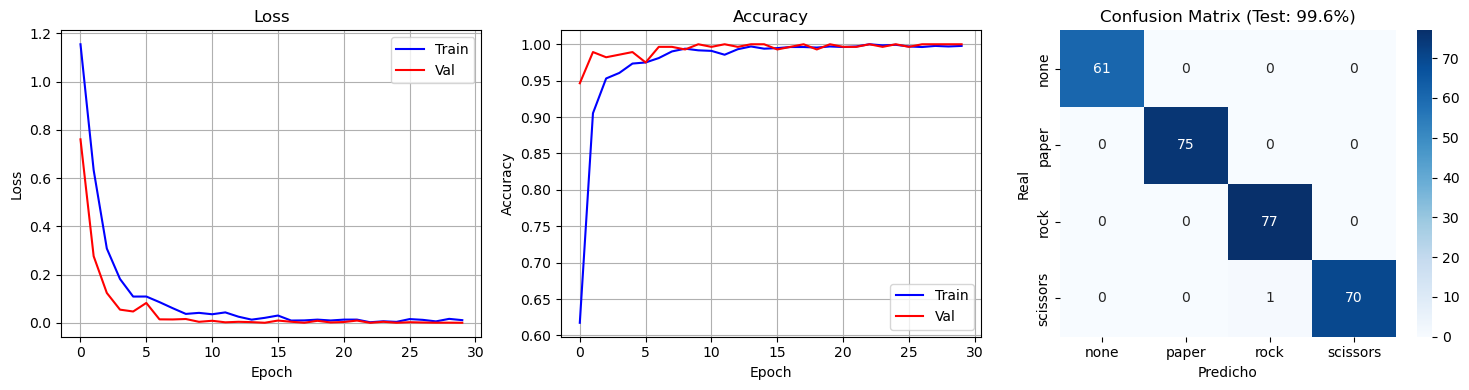

  Gráficas guardadas: results_myo.png

ENTRENAMIENTO COMPLETADO
  Mejor modelo: best_model_myo.pth
  Test Accuracy: 99.6%


In [10]:
# ============================================
# MAIN
# ============================================
if __name__ == "__main__":
    train()